Aegean assumes Gaussian noise. Polarised intensity has Ricean noise. How does this affect source finding?

To answer this question we'll simulate some Gaussian sources with both Gaussian and Ricean noise, and run Aegean on them.

In [292]:
import astropy.convolution
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy
import pandas
import AegeanTools.source_finder as aegean_source
from AegeanTools.models import GlobalFittingData
from tqdm import tqdm_notebook as tqdm

SIGMA_TO_FWHM = 2 * numpy.sqrt(2 * numpy.log(2))

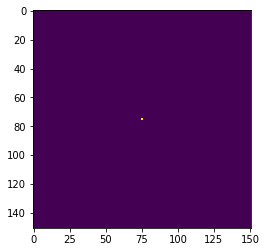

In [220]:
base_image = numpy.zeros((151, 151))
base_image[75, 75] = 1

plt.imshow(base_image)

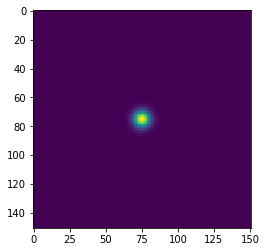

In [260]:
beam_sigma = 4
convolved_image = astropy.convolution.convolve(base_image, astropy.convolution.Gaussian2DKernel(beam_sigma))
convolved_image /= convolved_image.max()
plt.imshow(convolved_image)

In [324]:
noise_levels = numpy.linspace(0, 0.2, 100)
gaussian_noised = numpy.array([convolved_image + numpy.random.normal(scale=s) for s in noise_levels])
ricean_noised = numpy.sqrt([(convolved_image + numpy.random.normal(scale=s)) ** 2 +
                            (convolved_image + numpy.random.normal(scale=s)) ** 2 for s in noise_levels])

With some simple source images, we can now run Aegean on them.

In [325]:
beam = (SIGMA_TO_FWHM * beam_sigma / 60 / 60) ** 2

In [326]:
for i, im in enumerate(gaussian_noised):
    header = fits.Header()
    header['CTYPE1'] = 'RA--TAN'
    header['CRVAL1'] = 1
    header['CDELT1'] = -1 / 60 / 60
    header['CRPIX1'] = 1
    header['CTYPE2'] = 'DE--TAN'
    header['CRVAL2'] = 1
    header['CDELT2'] = -1 / 60 / 60
    header['CRPIX2'] = 1
    header['BMAJ'] = SIGMA_TO_FWHM * beam_sigma / 60 / 60
    header['BMIN'] = SIGMA_TO_FWHM * beam_sigma / 60 / 60
    header['BPA'] = 0
    fits.PrimaryHDU(data=im, header=header).writeto(f'gaussian_{i}.fits', overwrite=True)

In [327]:
for i, im in enumerate(ricean_noised):
    header = fits.Header()
    header['CTYPE1'] = 'RA--TAN'
    header['CRVAL1'] = 1
    header['CDELT1'] = -1 / 60 / 60
    header['CRPIX1'] = 1
    header['CTYPE2'] = 'DE--TAN'
    header['CRVAL2'] = 1
    header['CDELT2'] = -1 / 60 / 60
    header['CRPIX2'] = 1
    header['BMAJ'] = SIGMA_TO_FWHM * beam_sigma / 60 / 60
    header['BMIN'] = SIGMA_TO_FWHM * beam_sigma / 60 / 60
    header['BPA'] = 0
    fits.PrimaryHDU(data=im, header=header).writeto(f'ricean_{i}.fits', overwrite=True)

Aegean doesn't work from Python so we'll go run this on the command line.

```bash
for filename in *.fits; do BANE $filename --cores=1; done
for filename in gaussian_{0..99}.fits; do aegean --autoload $filename --table aegeanout_$filename.csv; done
for filename in ricean_{0..99}.fits; do aegean --autoload $filename --table aegeanout_$filename.csv; done
```

In [335]:
csvs = []
for i in range(100):
    csv = pandas.read_csv(f'aegeanout_gaussian_{i}.fits_comp.csv')
    if len(csv) > 1:
        ok = csv.ra_str == '00:03:55.00'
        assert ok.any()
        csv = csv[ok]
    csvs.append(csv)
cat_gaussian = pandas.concat(csvs, ignore_index=True)

csvs = []
for i in range(100):
    csv = pandas.read_csv(f'aegeanout_ricean_{i}.fits_comp.csv')
    if len(csv) > 1:
        ok = csv.ra_str == '00:03:55.00'
        assert ok.any()
        csv = csv[ok]
    csvs.append(csv)
cat_ricean = pandas.concat(csvs, ignore_index=True)
cat_ricean.shape, cat_gaussian.shape

((100, 27), (100, 27))

In [341]:
flux_i_gaussian = cat_gaussian.int_flux
flux_i_ricean = cat_ricean.int_flux
flux_p_gaussian = cat_gaussian.peak_flux
flux_p_ricean = cat_ricean.peak_flux
a_gaussian = cat_gaussian.a
a_ricean = cat_ricean.a

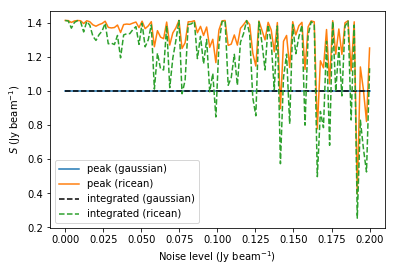

In [342]:
plt.plot(noise_levels, flux_p_gaussian, label='peak (gaussian)')
plt.plot(noise_levels, flux_p_ricean, label='peak (ricean)')
plt.plot(noise_levels, flux_i_gaussian, label='integrated (gaussian)', linestyle='--', c='k')
plt.plot(noise_levels, flux_i_ricean, label='integrated (ricean)', linestyle='--')
plt.xlabel('Noise level (Jy beam$^{-1}$)')
plt.ylabel('$S$ (Jy beam$^{-1}$)')
plt.legend()

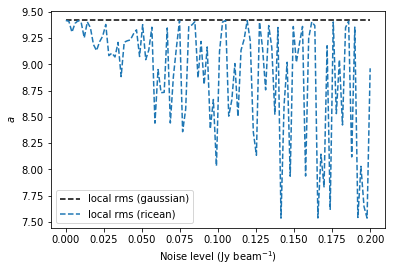

In [344]:
plt.plot(noise_levels, a_gaussian, label='local rms (gaussian)', linestyle='--', c='k')
plt.plot(noise_levels, a_ricean, label='local rms (ricean)', linestyle='--')
plt.xlabel('Noise level (Jy beam$^{-1}$)')
plt.ylabel('$a$')
plt.legend()